# Performing training (Noise2Noise) with L2-normalized spectra

## Loading libraries and configuration parameters

### Loading libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

In [2]:
from ddae1d.paths import PROJECT_ROOT

### Importing locally installed denoising autoencoder

In [3]:
from ddae1d.model import DiamondDAE1D

### Importing parameters from config file

In [4]:
with open("config.json") as f:
    config = json.load(f)

model_params = config["model_params"]
training_params = config["training_params"]

## Load data

In [5]:
noisy = np.load(PROJECT_ROOT / "data" / "preprocessed" / "trainset" / "noisy.npy")

In [6]:
print("Noisy data shape:", noisy.shape)

Noisy data shape: (704, 20, 736)


## L2 Normalisation of data before training

In order to keep a consistent scale across all spectra of each point, we use the L2-norm of the last repetition of the noisy spectra for each point. 

In [ ]:
# Compute L2 norms along the last axis
l2_norms = np.linalg.norm(noisy[:, -1, :], ord=2, axis=1, keepdims=True)[:, np.newaxis, :]
# Avoid division by zero
l2_norms_safe = np.where(l2_norms == 0, 1, l2_norms)

# Normalize
noisy_normed = noisy / l2_norms_safe

## Perform training

In [8]:
X_train = noisy_normed

In [9]:
print("Building model...")
model = DiamondDAE1D(**model_params)
# print("Model built.")

print("Training model...")
history = model.train_noise2noise(
    X_train,
    **training_params
)
print("Model trained.")

Building model...
Training model...
Epoch 1/500 - loss: 2.2759e-03
Epoch 2/500 - loss: 1.4620e-03
Epoch 3/500 - loss: 1.4305e-03
Epoch 4/500 - loss: 1.3794e-03
Epoch 5/500 - loss: 1.3918e-03
Epoch 6/500 - loss: 1.3754e-03
Epoch 7/500 - loss: 1.3750e-03
Epoch 8/500 - loss: 1.3701e-03
Epoch 9/500 - loss: 1.3717e-03
Epoch 10/500 - loss: 1.3788e-03
Epoch 11/500 - loss: 1.3771e-03
Epoch 12/500 - loss: 1.3718e-03
Epoch 13/500 - loss: 1.3735e-03
Epoch 14/500 - loss: 1.3683e-03
Epoch 15/500 - loss: 1.3738e-03
Epoch 16/500 - loss: 1.3707e-03
Epoch 17/500 - loss: 1.3769e-03
Epoch 18/500 - loss: 1.3665e-03
Epoch 19/500 - loss: 1.3723e-03
Epoch 20/500 - loss: 1.3685e-03
Epoch 21/500 - loss: 1.3666e-03
Epoch 22/500 - loss: 1.3639e-03
Epoch 23/500 - loss: 1.3676e-03
Epoch 24/500 - loss: 1.3699e-03
Epoch 25/500 - loss: 1.3628e-03
Epoch 26/500 - loss: 1.3667e-03
Epoch 27/500 - loss: 1.3635e-03
Epoch 28/500 - loss: 1.3631e-03
Epoch 29/500 - loss: 1.3614e-03
Epoch 30/500 - loss: 1.3668e-03
Epoch 31/500 

In [10]:
denoised_normed = model.predict(noisy_normed)

In [11]:
denoised = denoised_normed * l2_norms_safe

## Plot examples of denoised spectra noisy spectra 

In [12]:
n_rows = 4
n_cols = 4

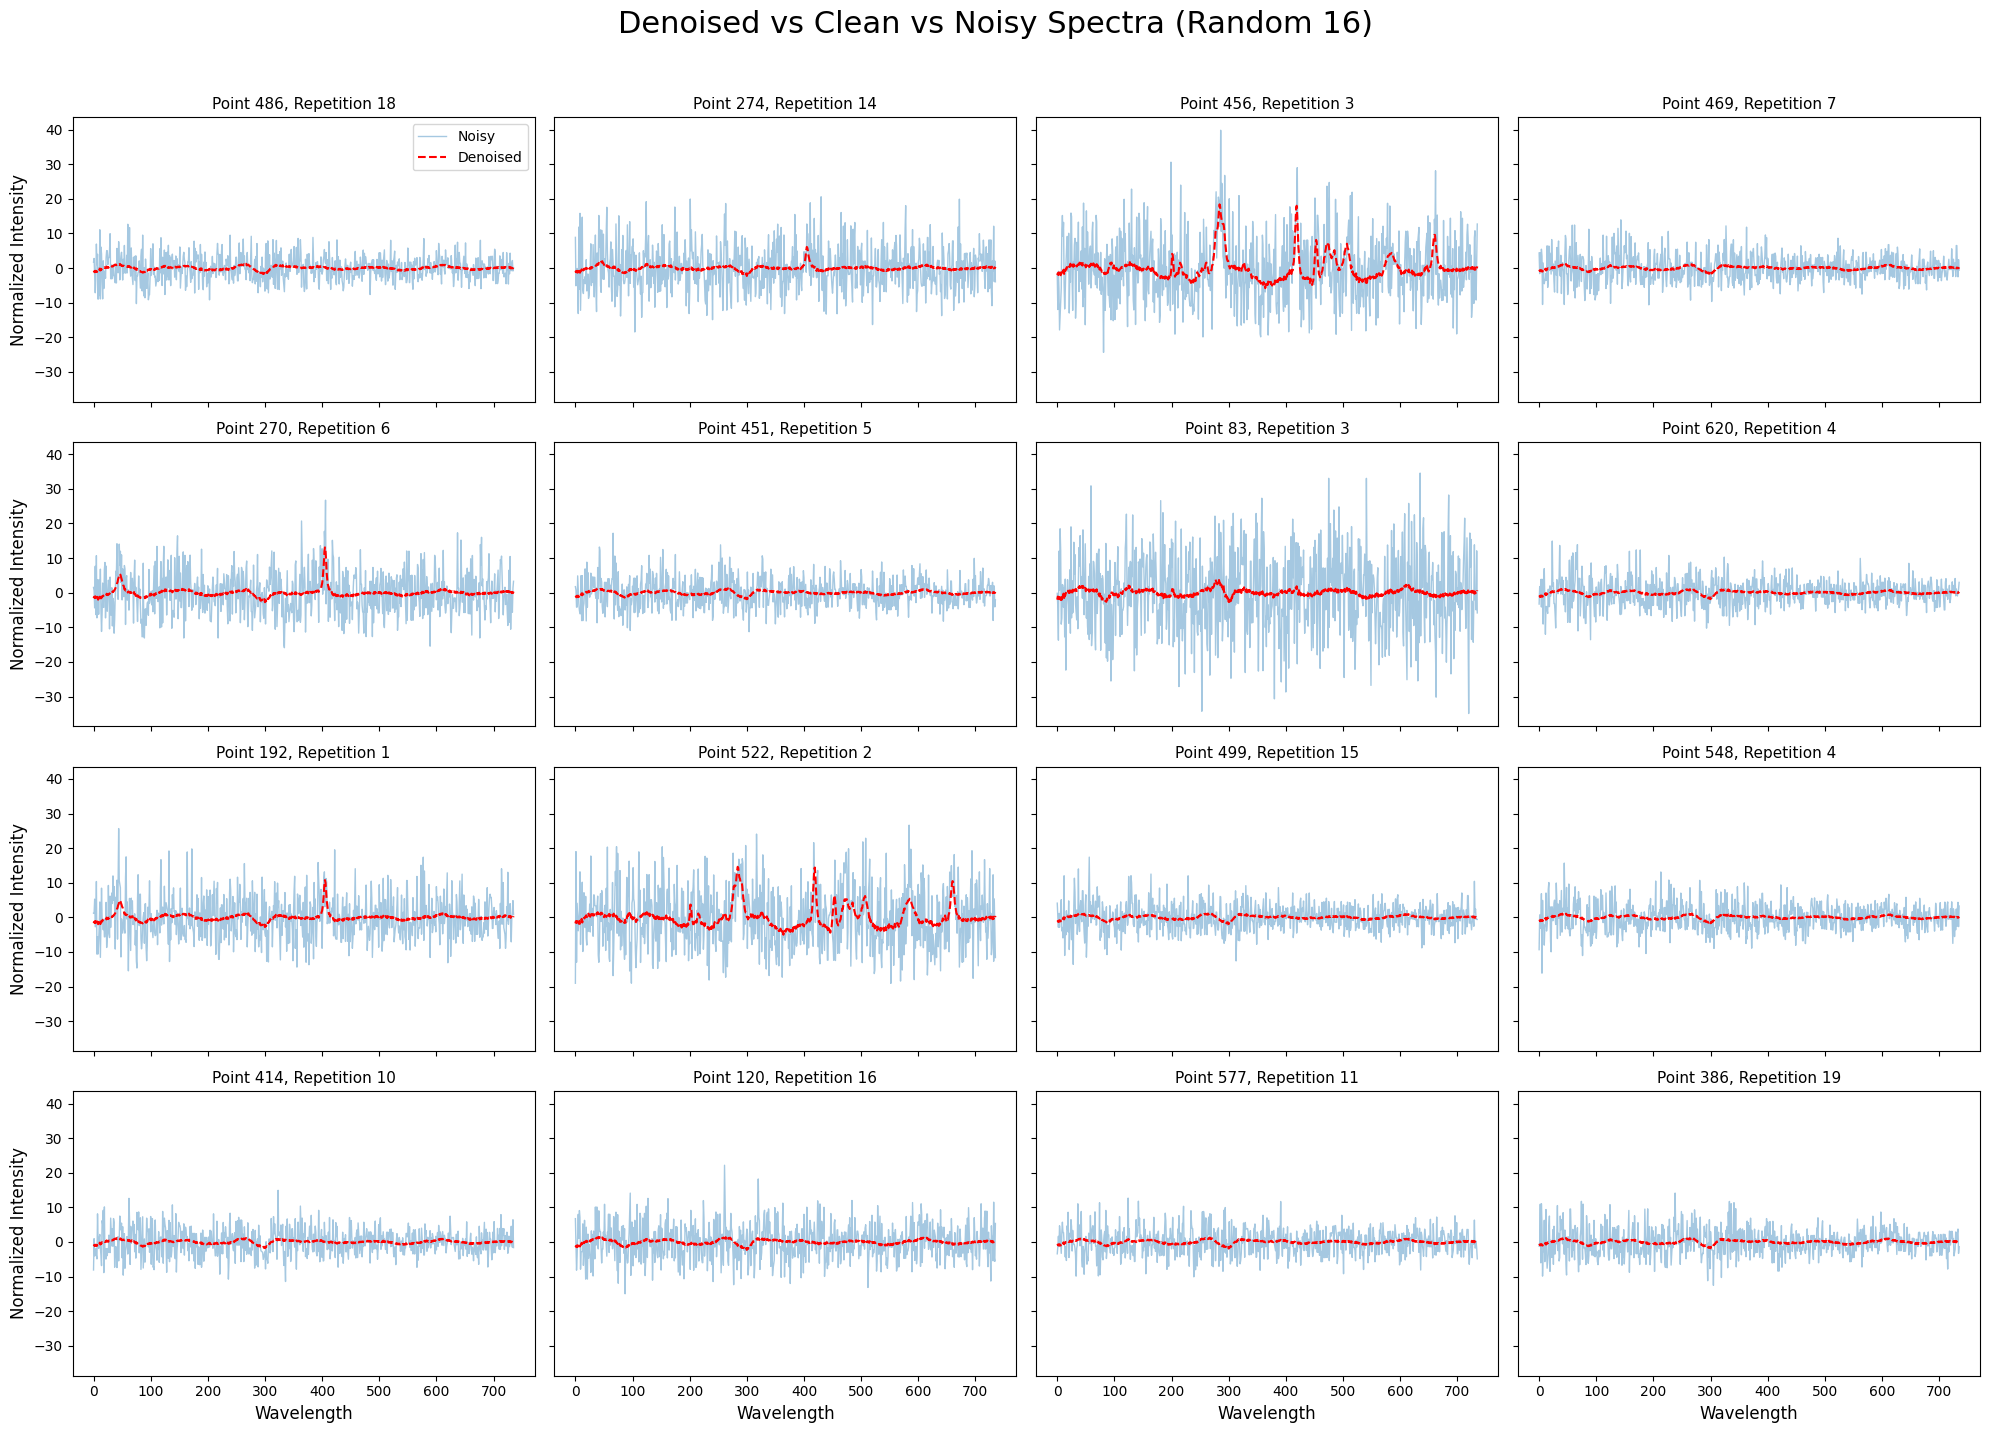

In [13]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 14), sharex=True, sharey=True)
axes = axes.flatten()
num_points = noisy.shape[0]
num_reps = noisy.shape[1]

pts = np.random.randint(0, num_points, size=n_rows * n_cols)
reps = np.random.randint(0, num_reps, size=n_rows * n_cols)
for i, ax in enumerate(axes):
    point = pts[i]
    rep = reps[i]
    ax.plot(noisy[point, rep], label='Noisy', color='C0', lw=1, alpha=0.4)
    ax.plot(denoised[point, rep], label='Denoised', color='red', lw=1.5, ls='--')
    ax.set_title(f"Point {point}, Repetition {rep}", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)
    if i % n_cols == 0:
        ax.set_ylabel("Normalized Intensity", fontsize=12)
    if i >= (n_rows - 1) * n_cols:
        ax.set_xlabel("Wavelength", fontsize=12)
    if i == 0:
        ax.legend(fontsize=10)

plt.suptitle(f"Denoised vs Clean vs Noisy Spectra (Random {n_rows * n_cols})", fontsize=22, y=1.02)
plt.tight_layout()
plt.show()